# Capstone Project - The Battle of the Neighborhoods (Week 2)
## Data Science Capstone Project by IBM/Coursera

### Introduction: Business Problem 

This project will find the top populer venue  of the selected locations. Also in this project we will try to find an location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an restaurant in Toronto, New York City.

Since there are lots of restaurants in neighbourhood we will try to detect the Indian cuisine are most popular in which areas. We are also particularly interested in areas with no Indian restaurants in vicinity. We would also prefer locations as close to city center as possible, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

### Data 
Based on definition of our problem, factors that will influence our decission are:

number of existing restaurants in the neighborhood (any type of restaurant)

Following data sources will be needed to extract/generate the required information:

centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using Google Maps API reverse geocoding
number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API


### Neighborhood Candidates
Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. 
Let's first find the latitude & longitude of New York city and Toronto, using specific, well known address and Google Maps geocoding API.

### Importing Libraries

In [216]:
import numpy as np # library to handle data in a vectorized manner
!pip install geopy
!pip install folium
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim

print('Libraries imported.')

Libraries imported.


In [217]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
print('Libraries imported.')

Libraries imported.


In [218]:
!pip install lxml
!pip install requests

### Import Neighbourhood Data for New York City and Toronto

In [219]:
#New York City Neighbourhood data

import urllib.request

print('Beginning file download with urllib2...')

url = 'https://cocl.us/new_york_dataset'
urllib.request.urlretrieve(url, 'newyork_data.json')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#newyork_data

neighborhoods_data = newyork_data['features']
#neighborhoods_data[0]

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

print('The New York City dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

Beginning file download with urllib2...
The New York City dataframe has 5 boroughs and 306 neighborhoods.


In [220]:
#Canada Neighbourhood Data

import requests
link= requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
df_Toronto=pd.read_html(link)[0]
df_Toronto.head(5)

print('The Toronto dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_Toronto['Borough'].unique()),
        df_Toronto.shape[0]
    )
)

The Toronto dataframe has 12 boroughs and 287 neighborhoods.


## Getting Co-Ordinates

In [241]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_NY = location.latitude
longitude_NY = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude_NY, longitude_NY))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [243]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_NY, longitude_NY], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [242]:
#Now we will find the coordinates of Toronto using Geolocator tool
address ='Toronto, T.O.'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude_TO = location.latitude
longitude_TO = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_TO, longitude_TO))

The geograpical coordinate of Toronto are 43.72090385, -79.3771857338025.


# This ssection is to use Foursquare data to get the venue details of the neighbourhood localities

## Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on venues in each neighborhood.

We're interested in venues in all category, for detecting the popular venues for tourists purpose. And then will check the popular restaurants and cuisine in the neighborhood.

Foursquare credentials are defined in hidden cell bellow.

In [ ]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 
VERSION = 'XXXXX' # Foursquare API version


In [245]:
LIMIT=100
RADIUS=500
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, RADIUS, LIMIT)

In [246]:
#Now we will create a dataframe with Toronto's neighborhoods and their coordinates

#get coordinates for the neighborhoods of Toronto
neigh_coordTO=[]
for name in df['Neighbourhood']:
    address_neig = ('{},Toronto, ON'.format(name))
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address_neig, timeout=10)
    if location == None:
        latitude_TO=0
        longitude_TO=0
    else :
        latitude_TO = location.latitude
        longitude_TO = location.longitude
    neigh_coordTO.append([name,latitude_TO,longitude_TO])

In [247]:
neig_coord_df_TO = pd.DataFrame(neigh_coordTO)
neig_coord_df_TO.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']
print(neig_coord_df_TO.shape)
neig_coord_df_TO.head()

(287, 3)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Not assigned,0.000000,0.000000
1,Not assigned,0.000000,0.000000
2,Parkwoods,43.758800,-79.320197
3,Victoria Village,43.732658,-79.311189
4,Harbourfront,43.640080,-79.380150


In [248]:
#Now we will create a dataframe with New Yorks neighborhoods and their coordinates

#get coordinates for the neighborhoods of New York
neigh_coordNY=[]
for name in neighborhoods['Neighborhood']:
    address_neig = ('{},New York, ON'.format(name))
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address_neig, timeout=10)
    if location == None:
        latitude_NY=0
        longitude_NY=0
    else :
        latitude_NY = location.latitude
        longitude_NY = location.longitude
    neigh_coordNY.append([name,latitude_NY,longitude_NY])

In [249]:
neig_coord_df_NY = pd.DataFrame(neigh_coordNY)
neig_coord_df_NY.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']
print(neig_coord_df_NY.shape)
neig_coord_df_NY.head()

(306, 3)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Wakefield,44.066192,-79.465830
1,Co-op City,53.103842,-0.173426
2,Eastchester,0.000000,0.000000
3,Fieldston,0.000000,0.000000
4,Riverdale,43.665470,-79.352594


# Data Cleaning: Removing columns and rows which have no co-ordinates

In [250]:
neig_coord_df_NY=neig_coord_df_NY.drop(neig_coord_df_NY[neig_coord_df_NY['Neighborhood Latitude']==0].index)

In [251]:
print(neig_coord_df_NY.shape)

(135, 3)


In [252]:
neig_coord_df_TO=neig_coord_df_TO.drop(neig_coord_df_TO[neig_coord_df_TO['Neighborhood Latitude']==0].index)

In [253]:
print(neig_coord_df_TO.shape)

(199, 3)


# Defining function to get values from Foursquare

In [254]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [255]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        LIMIT=100
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
NY_venues=getNearbyVenues(names=neig_coord_df_NY['Neighborhood'],
                               latitudes=neig_coord_df_NY['Neighborhood Latitude'],
                               longitudes=neig_coord_df_NY['Neighborhood Longitude'])

In [266]:
print(NY_venues.shape)
NY_venues.head()

(4927, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,44.066192,-79.465830,Houston Lock & Security,44.068225,-79.468063,Locksmith
1,Wakefield,44.066192,-79.465830,Canadiana Restaurant,44.065806,-79.471026,Breakfast Spot
2,Co-op City,53.103842,-0.173426,Co-op Food Store - Conningsby,53.104705,-0.173196,Food & Drink Shop
3,Co-op City,53.103842,-0.173426,Anna Green - PartyLite Candle Parties,53.103457,-0.174342,Gift Shop
4,Co-op City,53.103842,-0.173426,Penny's place cottage cafe,53.104741,-0.173392,Café


In [ ]:
toronto_venues=getNearbyVenues(names=neig_coord_df_TO['Neighborhood'],
                               latitudes=neig_coord_df_TO['Neighborhood Latitude'],
                               longitudes=neig_coord_df_TO['Neighborhood Longitude'])

In [267]:
print(toronto_venues.shape)
toronto_venues.head()

(6123, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7588,-79.320197,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.7588,-79.320197,LCBO,43.757774,-79.314257,Liquor Store
2,Parkwoods,43.7588,-79.320197,Petro-Canada,43.757950,-79.315187,Gas Station
3,Parkwoods,43.7588,-79.320197,Shoppers Drug Mart,43.760857,-79.324961,Pharmacy
4,Parkwoods,43.7588,-79.320197,TD Canada Trust,43.757569,-79.314976,Bank


# Count of total venues

In [268]:
# New York
count_NY_venues=NY_venues.groupby('Neighborhood').count()
count_NY_venues.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'],axis=1,inplace=True)
count_NY_venues.head(10)

,Venue
Neighborhood,
Allerton,28
Annadale,11
Arlington,11
Astoria,100
Auburndale,1
Bayside,4
Bayswater,36
Bedford Park,2
Bedford Stuyvesant,48


In [269]:
#Toronto
count_toronto_venues=toronto_venues.groupby('Neighborhood').count()
count_toronto_venues.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'],axis=1,inplace=True)
count_toronto_venues.head(10)

,Venue
Neighborhood,
Adelaide,100
Agincourt,13
Agincourt North,28
Albion Gardens,8
Alderwood,9
Bathurst Manor,4
Bathurst Quay,25
Bayview Village,11
Bedford Park,2


# Feature Engineering: One Hot Encoding

In [270]:
#NEW YORK
NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")
NY_onehot['Neighborhood'] = NY_venues['Neighborhood'] 

NY_onehot.set_index('Neighborhood',inplace=True)
NY_onehot.reset_index(inplace=True)
NY_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Internet Cafe,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,S

In [271]:
#TORONTO
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_onehot.set_index('Neighborhood',inplace=True)
toronto_onehot.reset_index(inplace=True)
toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Plane,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Sho

In [272]:
NY_onehot.shape

(4927, 354)

In [273]:
toronto_onehot.shape

(6123, 340)

# Inferantial Statistics

In [274]:
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Internet Cafe,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,S

In [275]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Plane,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Sho

In [276]:
toronto_grouped_Stats = toronto_onehot.groupby('Neighborhood').describe().reset_index()
toronto_grouped_Stats.head()

Neighborhood Accessories Store                                      \
                               count  mean  std  min  25%  50%  75%  max   
0         Adelaide             100.0  0.01  0.1  0.0  0.0  0.0  0.0  1.0   
1        Agincourt              13.0  0.00  0.0  0.0  0.0  0.0  0.0  0.0   
2  Agincourt North              28.0  0.00  0.0  0.0  0.0  0.0  0.0  0.0   
3   Albion Gardens               8.0  0.00  0.0  0.0  0.0  0.0  0.0  0.0   
4        Alderwood               9.0  0.00  0.0  0.0  0.0  0.0  0.0  0.0   

  Afghan Restaurant                                    African Restaurant  \
              count mean  std  min  25%  50%  75%  max              count   
0             100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              100.0   
1              13.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0               13.0   
2              28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0               28.0   
3               8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                8.0   
4               9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                9.0   

                                     Airport                                \
  mean  std  min  25%  50%  75%  max   count mean  std  min  25%  50%  75%   
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   100.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    13.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0    28.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0     8.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0     9.0  0.0  0.0  0.0  0.0  0.0  0.0   

       Airport Food Court                                    Airport Gate  \
   max              count mean  std  min  25%  50%  75%  max        count   
0  0.0              100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        100.0   
1  0.0               13.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         13.0   
2  0.0               28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         28.0   
3  0.0                8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          8.0   
4  0.0                9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          9.0   

                                     Airport Lounge                           \
  mean  std  min  25%  50%  75%  max          count mean  std  min  25%  50%   
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          100.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0           13.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0           28.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0            8.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0            9.0  0.0  0.0  0.0  0.0  0.0   

            Airport Service                                     \
   75%  max           count mean  std  min  25%  50%  75%  max   
0  0.0  0.0           100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0            13.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0            28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0             8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0             9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

  Airport Terminal                                    American Restaurant  \
             count mean  std  min  25%  50%  75%  max               count   
0            100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0               100.0   
1             13.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                13.0   
2             28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                28.0   
3              8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                 8.0   
4              9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                 9.0   

                                           Antique Shop                      \
   mean       std  min  25%  50%  75%  max        count mean  std  min  25%   
0  0.03  0.171447  0.0  0.0  0.0  0.0  1.0        100.0  0.0  0.0  0.0  0.0   
1  0.00  0.000000  0.0  0.0  0.0  0.0  0.0   

In [277]:
NY_grouped_Stats = NY_onehot.groupby('Neighborhood').describe().reset_index()
NY_grouped_Stats.head()

Neighborhood    ATM                                    Accessories Store  \
                count mean  std  min  25%  50%  75%  max             count   
0     Allerton   28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              28.0   
1     Annadale   11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              11.0   
2    Arlington   11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              11.0   
3      Astoria  100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0             100.0   
4   Auburndale    1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0               1.0   

                                     Adult Boutique                           \
  mean  std  min  25%  50%  75%  max          count mean  std  min  25%  50%   
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0           28.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0           11.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0           11.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0          100.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  NaN  0.0  0.0  0.0  0.0  0.0            1.0  0.0  NaN  0.0  0.0  0.0   

            African Restaurant                                     \
   75%  max              count mean  std  min  25%  50%  75%  max   
0  0.0  0.0               28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0               11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0               11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0              100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0                1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0   

  American Restaurant                                               \
                count      mean       std  min  25%  50%  75%  max   
0                28.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
1                11.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
2                11.0  0.090909  0.301511  0.0  0.0  0.0  0.0  1.0   
3               100.0  0.010000  0.100000  0.0  0.0  0.0  0.0  1.0   
4                 1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0   

  Amphitheater                                    Antique Shop                 \
         count mean  std  min  25%  50%  75%  max        count mean  std  min   
0         28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         28.0  0.0  0.0  0.0   
1         11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         11.0  0.0  0.0  0.0   
2         11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         11.0  0.0  0.0  0.0   
3        100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        100.0  0.0  0.0  0.0   
4          1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0          1.0  0.0  NaN  0.0   

                      Aquarium                                    Arcade       \
   25%  50%  75%  max    count mean  std  min  25%  50%  75%  max  count mean   
0  0.0  0.0  0.0  0.0     28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   28.0  0.0   
1  0.0  0.0  0.0  0.0     11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   11.0  0.0   
2  0.0  0.0  0.0  0.0     11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   11.0  0.0   
3  0.0  0.0  0.0  0.0    100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  100.0  0.0   
4  0.0  0.0  0.0  0.0      1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0    1.0  0.0   

                                Arepa Restaurant                            \
   std  min  25%  50%  75%  max            count  mean  std  min  25%  50%   
0  0.0  0.0  0.0  0.0  0.0  0.0             28.0  0.00  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0             11.0  0.00  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0             11.0  0.00  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0            100.0  0.01  0.1  0.0  0.0  0.0   
4  NaN  0.0  0.0  0.0  0.0  0.0              1.0  0.00  NaN  0.0  0.0  0.0   

            Argentinian Restaurant                                     \
   75%  max                  count mean  std  min  25%  50%  75%  max   
0  0.0  0.0                   28.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0      

# Getting the India restaurant statistics

In [278]:
#NEW YORK

NY_grouped_IND_Res = NY_onehot.groupby('Neighborhood').sum().sort_values('Indian Restaurant', ascending = False)
NY_grouped_IND_Res['Indian Restaurant'].loc[(NY_grouped_IND_Res['Indian Restaurant']!=0)]

Neighborhood
Bloomfield             5
Manhattan Valley       4
Murray Hill            4
Greenwich Village      4
Morningside Heights    3
Lenox Hill             3
Turtle Bay             3
Upper East Side        3
Long Island City       3
Chelsea                2
Steinway               2
Astoria                2
Sunnyside Gardens      2
Soho                   1
South Jamaica          1
Kensington             1
Co-op City             1
High  Bridge           1
Hamilton Heights       1
Park Hill              1
Prospect Heights       1
Morris Park            1
Williamsburg           1
Upper West Side        1
Bushwick               1
Midtown South          1
Brooklyn Heights       1
Boerum Hill            1
Name: Indian Restaurant, dtype: uint8

In [135]:
#TORONTO

toronto_grouped_IND_Res = toronto_onehot.groupby('Neighborhood').sum().sort_values('Indian Restaurant', ascending = False)
toronto_grouped_IND_Res['Indian Restaurant'].loc[(toronto_grouped_IND_Res['Indian Restaurant']!=0)]


Neighborhood
India Bazaar             8
Thistletown              3
Christie                 2
Cabbagetown              2
The Annex                2
St. James Town           2
South of Bloor           2
Thorncliffe Park         2
Runnymede                2
Yorkville                2
Princess Gardens         2
Parkdale Village         2
Parkdale                 2
Queen's Park             1
Harbourfront             1
Dufferin                 1
The Kingsway             1
The Junction South       1
The Junction North       1
The Danforth West        1
Fairview                 1
Montgomery Road          1
Grange Park              1
Harbourfront West        1
Harbourfront East        1
Royal York South East    1
Maryvale                 1
South Hill               1
Mount Olive              1
Jamestown                1
Martin Grove             1
Royal York South West    1
King and Spadina         1
New Toronto              1
North Midtown            1
Wexford Heights          1
CN Tower       

# Plotting Indian Restaurant

In [279]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

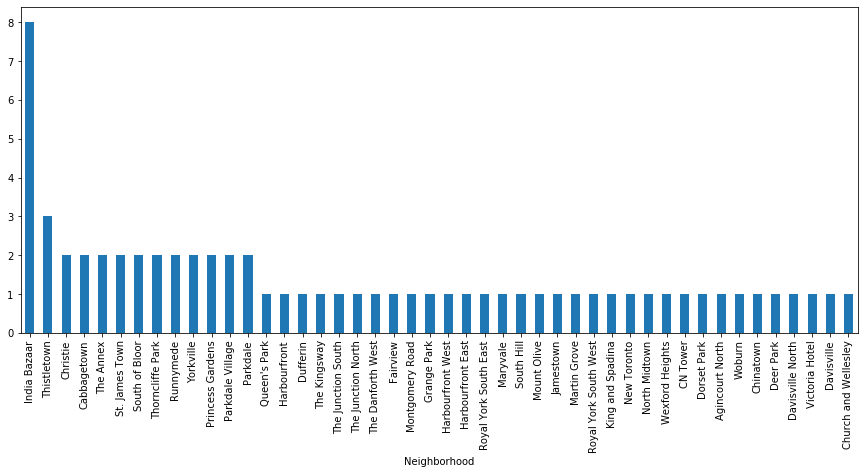

In [280]:
#toronto_grouped_IND_Res['Indian Restaurant'].isnull().plot()

toronto_grouped_IND_Res['Indian Restaurant'].loc[(toronto_grouped_IND_Res['Indian Restaurant']!=0)].plot(kind='bar',figsize=(15, 6))

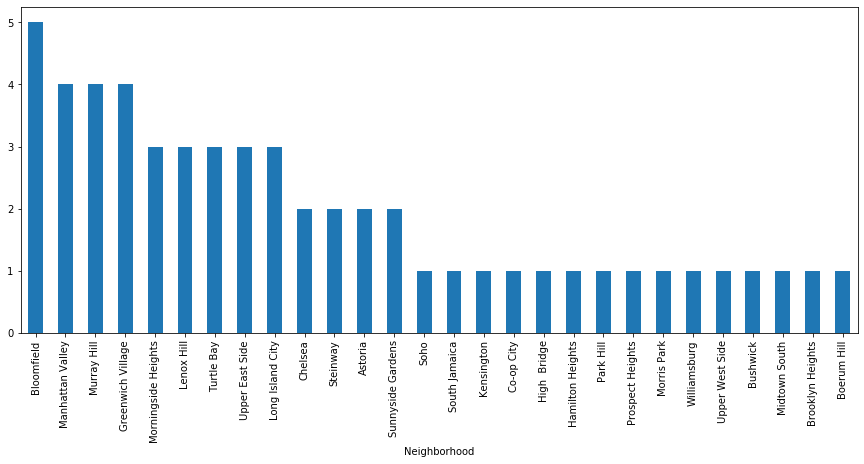

In [157]:
NY_grouped_IND_Res['Indian Restaurant'].loc[(NY_grouped_IND_Res['Indian Restaurant']!=0)].plot(kind='bar',figsize=(15, 6))

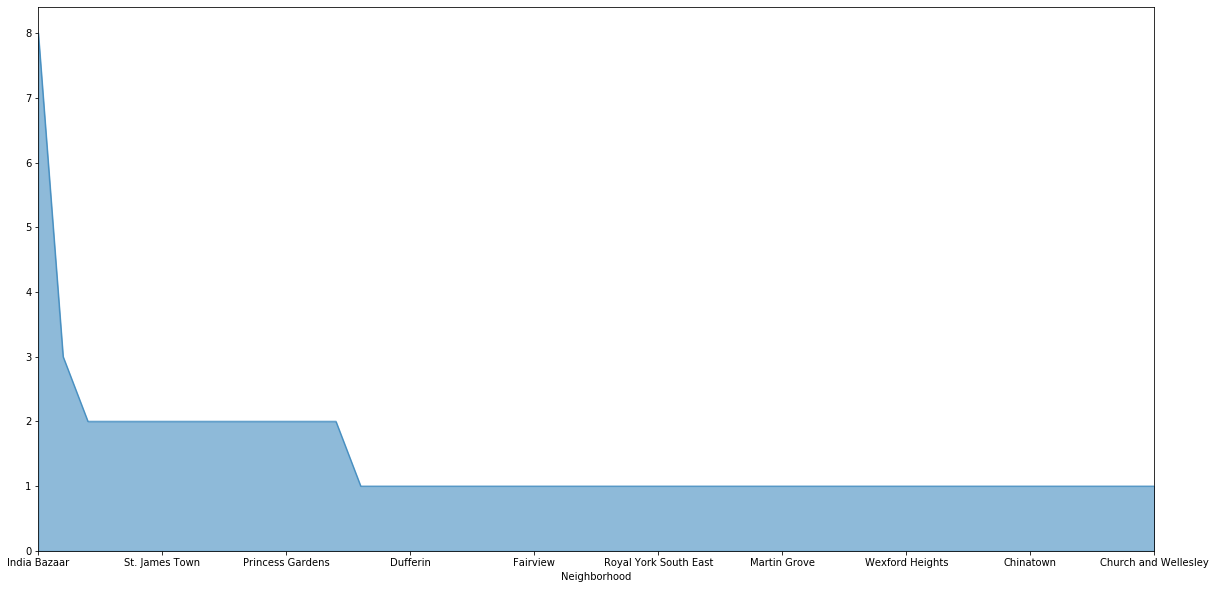

In [281]:

toronto_grouped_IND_Res['Indian Restaurant'].loc[(toronto_grouped_IND_Res['Indian Restaurant']!=0)].plot(kind='area', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             )

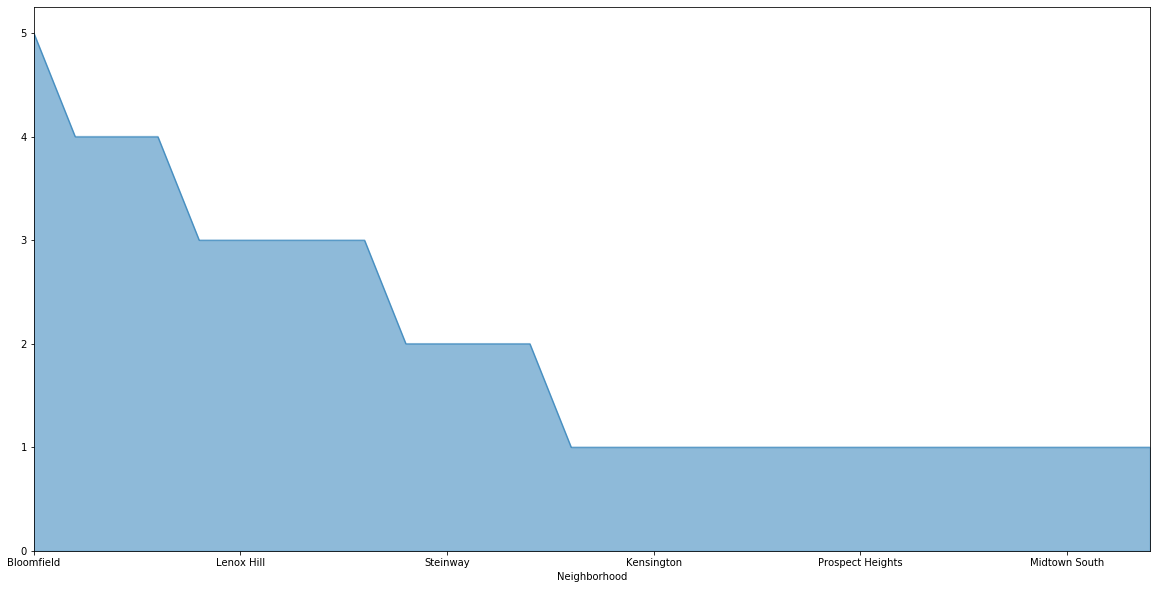

In [282]:
NY_grouped_IND_Res['Indian Restaurant'].loc[(NY_grouped_IND_Res['Indian Restaurant']!=0)].plot(kind='area', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             )

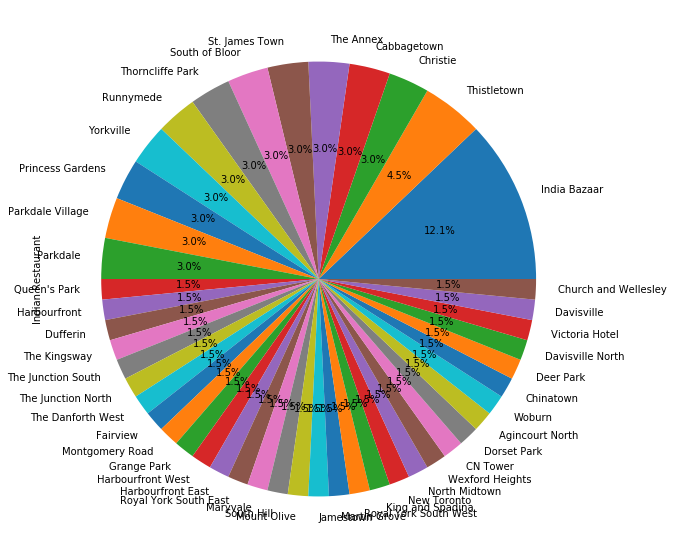

In [283]:
toronto_grouped_IND_Res['Indian Restaurant'].loc[(toronto_grouped_IND_Res['Indian Restaurant']!=0)].plot(kind='pie',
                                                                                                        figsize=(20, 10),
                                                                                                         autopct='%1.1f%%')

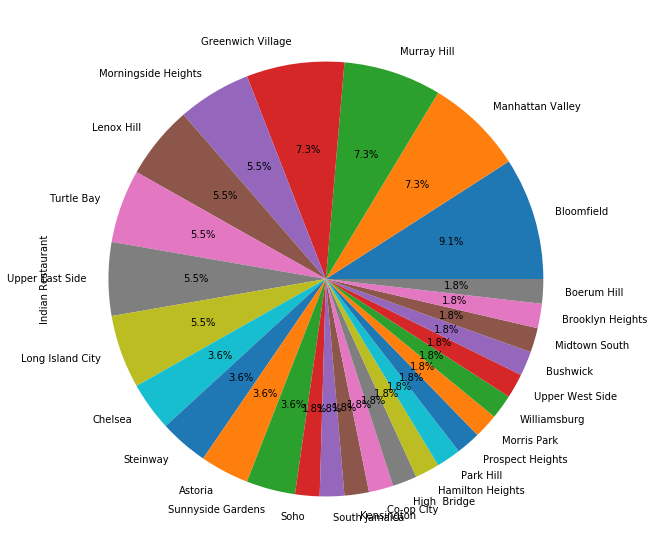

In [168]:
NY_grouped_IND_Res['Indian Restaurant'].loc[(NY_grouped_IND_Res['Indian Restaurant']!=0)].plot(kind='pie',
                                                                                                        figsize=(20, 10),
                                                                                                         autopct='%1.1f%%')

In [284]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [285]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted___NY = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted___NY['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    neighborhoods_venues_sorted___NY.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted___NY.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Coffee Shop,Bakery,Middle Eastern Restaurant,Café,Pharmacy,Grocery Store,Gymnastics Gym,Fast Food Restaurant,Liquor Store,Bank
1,Annadale,Restaurant,Dance Studio,Cosmetics Shop,Pharmacy,Train Station,Food,Pizza Place,Park,Diner,Sports Bar
2,Arlington,Deli / Bodega,Convenience Store,Shipping Store,Mexican Restaurant,Sandwich Place,Pizza Place,Martial Arts Dojo,Breakfast Spot,Japanese Restaurant,American Restaurant
3,Astoria,Bar,Bakery,Pizza Place,Greek Restaurant,Grocery Store,Food Truck,Italian Restaurant,Salon / Barbershop,Café,Burger Joint
4,Auburndale,Pool,Zoo Exhibit,Fountain,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court


In [175]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted___TO = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted___TO['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted___TO.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted___TO.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Hotel,Restaurant,Gastropub,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,American Restaurant,Asian Restaurant
1,Agincourt,Chinese Restaurant,Business Service,Food Court,Vietnamese Restaurant,Hong Kong Restaurant,Korean Restaurant,Asian Restaurant,Rental Car Location,Coffee Shop,Train Station
2,Agincourt North,Chinese Restaurant,Ice Cream Shop,Bakery,Sandwich Place,Taco Place,Beer Store,Liquor Store,Fried Chicken Joint,Spa,Fast Food Restaurant
3,Albion Gardens,Grocery Store,Fried Chicken Joint,Pizza Place,Hardware Store,Fast Food Restaurant,Pharmacy,Beer Store,Sandwich Place,Falafel Restaurant,Electronics Store
4,Alderwood,Pizza Place,Pool,Gym,Pub,Skating Rink,Sandwich Place,Pharmacy,Coffee Shop,Ethiopian Restaurant,Eastern European Restaurant


# Cluster Neighborhood

In [297]:
# set number of clusters
kclusters = 5

NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0])

In [298]:
# add clustering labels
neighborhoods_venues_sorted___NY.insert(0, 'Cluster Labels NY', kmeans.labels_)

NY_merged = neig_coord_df_NY

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(neighborhoods_venues_sorted___NY.set_index('Neighborhood'), on='Neighborhood')

NY_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels NY,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,44.066192,-79.465830,0.0,0.0,Breakfast Spot,Locksmith,Zoo Exhibit,Fountain,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
1,Co-op City,53.103842,-0.173426,0.0,0.0,Gift Shop,Café,Indian Restaurant,Food & Drink Shop,Zoo Exhibit,Food Truck,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
4,Riverdale,43.665470,-79.352594,0.0,0.0,Chinese Restaurant,Vietnamese Restaurant,Bakery,Bar,Light Rail Station,Grocery Store,Café,Baseball Field,Fish Market,Chocolate Shop
5,Kingsbridge,43.814385,-79.455471,0.0,0.0,Coffee Shop,Clothing Store,BBQ Joint,Hockey Arena,Pharmacy,Sandwich Place,Mediterranean Restaurant,Bagel Shop,Gym,Electronics Store
7,Woodlawn,43.879477,-79.289947,0.0,0.0,Shoe Store,Chinese Restaurant,Hong Kong Restaurant,Sandwich Place,Fruit & Vegetable Store,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


In [299]:
NY_merged.dropna(axis=0,inplace=True)
NY_merged['Cluster Labels NY'] = NY_merged['Cluster Labels NY'].astype(int)
#print(toronto_merged.dtypes)
NY_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels NY,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,44.066192,-79.465830,0,0.0,Breakfast Spot,Locksmith,Zoo Exhibit,Fountain,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
1,Co-op City,53.103842,-0.173426,0,0.0,Gift Shop,Café,Indian Restaurant,Food & Drink Shop,Zoo Exhibit,Food Truck,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
4,Riverdale,43.665470,-79.352594,0,0.0,Chinese Restaurant,Vietnamese Restaurant,Bakery,Bar,Light Rail Station,Grocery Store,Café,Baseball Field,Fish Market,Chocolate Shop
5,Kingsbridge,43.814385,-79.455471,0,0.0,Coffee Shop,Clothing Store,BBQ Joint,Hockey Arena,Pharmacy,Sandwich Place,Mediterranean Restaurant,Bagel Shop,Gym,Electronics Store
7,Woodlawn,43.879477,-79.289947,0,0.0,Shoe Store,Chinese Restaurant,Hong Kong Restaurant,Sandwich Place,Fruit & Vegetable Store,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


In [301]:
# create map
map_clusters_NY = folium.Map(location=[latitude_NY, longitude_NY], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_merged['Neighborhood Latitude'], NY_merged['Neighborhood Longitude'], NY_merged['Neighborhood'], NY_merged['Cluster Labels NY']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_NY)
       
map_clusters_NY

In [308]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 0])

In [309]:
# add clustering labels
neighborhoods_venues_sorted___TO.insert(0, 'Cluster Labels TOR', kmeans.labels_)

toronto_merged = neig_coord_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted___TO.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels TOR,Cluster Labels TO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,44.066192,-79.465830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Co-op City,53.103842,-0.173426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Eastchester,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fieldston,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Riverdale,43.665470,-79.352594,0.0,0.0,0.0,Chinese Restaurant,Vietnamese Restaurant,Bakery,Grocery Store,Bar,Light Rail Station,Breakfast Spot,Baseball Field,Cheese Shop,Chocolate Shop


In [311]:
toronto_merged.dropna(axis=0,inplace=True)
toronto_merged['Cluster Labels TOR'] = toronto_merged['Cluster Labels TOR'].astype(int)
#print(toronto_merged.dtypes)
toronto_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels TOR,Cluster Labels TO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,43.665470,-79.352594,0,0.0,0.0,Chinese Restaurant,Vietnamese Restaurant,Bakery,Grocery Store,Bar,Light Rail Station,Breakfast Spot,Baseball Field,Cheese Shop,Chocolate Shop
13,Bedford Park,43.737388,-79.410925,0,0.0,0.0,Gym / Fitness Center,Seafood Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
100,Chinatown,43.706339,-79.505084,0,0.0,0.0,Café,Bar,Vietnamese Restaurant,Mexican Restaurant,Chinese Restaurant,Dessert Shop,Coffee Shop,Cocktail Bar,Dumpling Restaurant,Bakery
108,Yorkville,39.204499,-84.967455,0,0.0,0.0,Café,Italian Restaurant,Boutique,Coffee Shop,Restaurant,French Restaurant,Hotel,Japanese Restaurant,Spa,Women's Store
169,Rosedale,29.992645,-90.226875,3,3.0,3.0,Park,Food Truck,Playground,Bike Trail,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [312]:
# create map
map_clusters_TO = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels TOR']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_TO)
       
map_clusters_TO

# NEW YORK

In [313]:
NY_merged.loc[NY_merged['Cluster Labels'] == 0, NY_merged.columns[[0] + list(range(4, NY_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,0.0,Breakfast Spot,Locksmith,Zoo Exhibit,Fountain,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
1,Co-op City,0.0,Gift Shop,Café,Indian Restaurant,Food & Drink Shop,Zoo Exhibit,Food Truck,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
4,Riverdale,0.0,Chinese Restaurant,Vietnamese Restaurant,Bakery,Bar,Light Rail Station,Grocery Store,Café,Baseball Field,Fish Market,Chocolate Shop
5,Kingsbridge,0.0,Coffee Shop,Clothing Store,BBQ Joint,Hockey Arena,Pharmacy,Sandwich Place,Mediterranean Restaurant,Bagel Shop,Gym,Electronics Store
7,Woodlawn,0.0,Shoe Store,Chinese Restaurant,Hong Kong Restaurant,Sandwich Place,Fruit & Vegetable Store,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
8,Norwood,0.0,Skating Rink,Thai Restaurant,Park,Church,Caribbean Restaurant,BBQ Joint,Restaurant,Light Rail Station,Coffee Shop,Train Station
12,City Island,0.0,Harbor / Marina,Boat or Ferry,Deli / Bodega,Park,Thrift / Vintage Store,Bar,Pizza Place,Spanish Restaurant,Diner,French Restaurant
13,Bedford Park,0.0,Seafood Restaurant,Gym / Fitness Center,Zoo Exhibit,Food Court,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food
19,High Bridge,0.0,Chinese Restaurant,Deli / Bodega,Bar,Fried Chicken Joint,American Restaurant,Grocery Store,Burger Joint,Pizza Place,Donut Shop,Speakeasy
23,Longwood,0.0,Theme Park Ride / Attraction,Camera Store,Hotel,Zoo Exhibit,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food


In [314]:
NY_merged.loc[NY_merged['Cluster Labels'] == 1, NY_merged.columns[[0] + list(range(4, NY_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,Red Hook,1.0,Waterfall,Zoo Exhibit,Fountain,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop


In [315]:
NY_merged.loc[NY_merged['Cluster Labels'] == 2, NY_merged.columns[[0] + list(range(4, NY_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Melrose,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
96,North Side,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
130,Woodside,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
140,Sunnyside,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
144,Glendale,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
163,Hollis,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
169,Rosedale,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
185,Hillcrest,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
200,Rosebank,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
212,Oakwood,2.0,Smoke Shop,Zoo Exhibit,Gastropub,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop


In [316]:
NY_merged.loc[NY_merged['Cluster Labels'] == 3, NY_merged.columns[[0] + list(range(4, NY_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Fordham,3.0,Basketball Court,Tennis Court,Café,Pool,Zoo Exhibit,Food Truck,Fish Market,Flea Market,Flower Shop,Food
152,Auburndale,3.0,Pool,Zoo Exhibit,Fountain,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court


In [317]:
NY_merged.loc[NY_merged['Cluster Labels'] == 4, NY_merged.columns[[0] + list(range(4, NY_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Morris Park,4.0,Intersection,Park,Indian Restaurant,Coffee Shop,Mobile Phone Shop,Zoo Exhibit,Food Court,Fish & Chips Shop,Fish Market,Flea Market
159,Briarwood,4.0,Intersection,Flower Shop,Convenience Store,Spa,Zoo Exhibit,Fountain,Fish & Chips Shop,Fish Market,Flea Market,Food
164,South Jamaica,4.0,Intersection,Park,Indian Restaurant,Coffee Shop,Mobile Phone Shop,Zoo Exhibit,Food Court,Fish & Chips Shop,Fish Market,Flea Market
167,Springfield Gardens,4.0,Caribbean Restaurant,Intersection,Bakery,Juice Bar,Park,Pizza Place,Restaurant,Bus Station,Deli / Bodega,Arcade
168,Cambria Heights,4.0,Caribbean Restaurant,Intersection,Bakery,Juice Bar,Park,Pizza Place,Restaurant,Bus Station,Deli / Bodega,Arcade
280,Vinegar Hill,4.0,Intersection,Zoo Exhibit,Food Truck,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop


## TORONTO

In [318]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels TO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,0.0,0.0,Chinese Restaurant,Vietnamese Restaurant,Bakery,Grocery Store,Bar,Light Rail Station,Breakfast Spot,Baseball Field,Cheese Shop,Chocolate Shop
13,Bedford Park,0.0,0.0,Gym / Fitness Center,Seafood Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
100,Chinatown,0.0,0.0,Café,Bar,Vietnamese Restaurant,Mexican Restaurant,Chinese Restaurant,Dessert Shop,Coffee Shop,Cocktail Bar,Dumpling Restaurant,Bakery
108,Yorkville,0.0,0.0,Café,Italian Restaurant,Boutique,Coffee Shop,Restaurant,French Restaurant,Hotel,Japanese Restaurant,Spa,Women's Store


In [319]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels TO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [320]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels TO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [321]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels TO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
169,Rosedale,3.0,3.0,Park,Food Truck,Playground,Bike Trail,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [322]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels TO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [323]:
num_top_venues = 5

for hood in NY_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NY_grouped[NY_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                       venue  freq
0                Coffee Shop  0.14
1                     Bakery  0.07
2                       Café  0.07
3  Middle Eastern Restaurant  0.07
4              Shopping Mall  0.04


----Annadale----
            venue  freq
0      Restaurant  0.18
1  Cosmetics Shop  0.09
2      Sports Bar  0.09
3            Park  0.09
4            Food  0.09


----Arlington----
                venue  freq
0      Breakfast Spot  0.09
1       Deli / Bodega  0.09
2  Mexican Restaurant  0.09
3   Martial Arts Dojo  0.09
4      Shipping Store  0.09


----Astoria----
              venue  freq
0               Bar  0.06
1       Pizza Place  0.04
2     Grocery Store  0.04
3            Bakery  0.04
4  Greek Restaurant  0.04


----Auburndale----
                   venue  freq
0                   Pool   1.0
1            Pet Service   0.0
2    Peruvian Restaurant   0.0
3     Persian Restaurant   0.0
4  Performing Arts Venue   0.0


----Bayside----
                venue  

               venue  freq
0  Mobile Phone Shop  0.06
1              Diner  0.06
2               Bank  0.06
3        Supermarket  0.03
4        Coffee Shop  0.03


----Financial District----
         venue  freq
0  Coffee Shop  0.12
1         Café  0.07
2        Hotel  0.06
3   Restaurant  0.04
4       Bakery  0.03


----Flatbush----
                  venue  freq
0                  Café  0.06
1  Caribbean Restaurant  0.06
2          Cocktail Bar  0.04
3   American Restaurant  0.04
4             Wine Shop  0.04


----Flushing----
                venue  freq
0  Italian Restaurant  0.25
1       Deli / Bodega  0.25
2          Playground  0.25
3  Athletics & Sports  0.25
4                 ATM  0.00


----Fordham----
               venue  freq
0               Pool  0.25
1   Basketball Court  0.25
2       Tennis Court  0.25
3               Café  0.25
4  Paella Restaurant  0.00


----Fort Greene----
            venue  freq
0          Lounge  0.04
1     Coffee Shop  0.04
2     Pizza Place  0.04

                  venue  freq
0          Skating Rink  0.15
1            Restaurant  0.08
2    Light Rail Station  0.08
3                  Park  0.08
4  Caribbean Restaurant  0.08


----Oakwood----
                                      venue  freq
0                                Smoke Shop   1.0
1                                       ATM   0.0
2  Residential Building (Apartment / Condo)   0.0
3                       Peruvian Restaurant   0.0
4                        Persian Restaurant   0.0


----Old Town----
                     venue  freq
0                    Diner  0.05
1       Falafel Restaurant  0.05
2  New American Restaurant  0.05
3                     Park  0.05
4  Fruit & Vegetable Store  0.05


----Park Hill----
               venue  freq
0          Gift Shop  0.25
1  Food & Drink Shop  0.25
2  Convenience Store  0.25
3  Indian Restaurant  0.25
4                ATM  0.00


----Park Slope----
                venue  freq
0  Italian Restaurant  0.07
1                Café  0.0

                venue  freq
0            Pharmacy  0.11
1         Pizza Place  0.08
2          Donut Shop  0.08
3  Italian Restaurant  0.08
4       Deli / Bodega  0.08


----Williamsburg----
                venue  freq
0                 Bar  0.11
1         Coffee Shop  0.09
2  Italian Restaurant  0.07
3  Mexican Restaurant  0.03
4          Restaurant  0.03


----Willowbrook----
                  venue  freq
0        Discount Store  0.11
1     Korean Restaurant  0.11
2  Hong Kong Restaurant  0.11
3           Coffee Shop  0.11
4                  Park  0.11


----Woodhaven----
                       venue  freq
0       Fast Food Restaurant  0.14
1  Latin American Restaurant  0.14
2        Fried Chicken Joint  0.14
3                Pizza Place  0.10
4             Discount Store  0.05


----Woodlawn----
                           venue  freq
0             Chinese Restaurant  0.25
1                     Shoe Store  0.25
2           Hong Kong Restaurant  0.25
3                 Sandwich Place  

In [210]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
         venue  freq
0  Coffee Shop  0.09
1         Café  0.07
2        Hotel  0.05
3   Restaurant  0.04
4    Gastropub  0.04


----Agincourt----
                   venue  freq
0     Chinese Restaurant  0.31
1  Vietnamese Restaurant  0.08
2       Asian Restaurant  0.08
3      Korean Restaurant  0.08
4       Business Service  0.08


----Agincourt North----
                  venue  freq
0                Bakery  0.07
1    Chinese Restaurant  0.07
2        Ice Cream Shop  0.07
3     Indian Restaurant  0.04
4  Fast Food Restaurant  0.04


----Albion Gardens----
                  venue  freq
0   Fried Chicken Joint  0.12
1           Pizza Place  0.12
2         Grocery Store  0.12
3  Fast Food Restaurant  0.12
4        Sandwich Place  0.12


----Alderwood----
            venue  freq
0     Pizza Place  0.22
1             Pub  0.11
2             Gym  0.11
3  Sandwich Place  0.11
4     Coffee Shop  0.11


----Bathurst Manor----
               venue  freq
0               Park  0.

                   venue  freq
0  Performing Arts Venue   1.0
1      Accessories Store   0.0
2           Noodle House   0.0
3        Other Nightlife   0.0
4   Other Great Outdoors   0.0


----Emery----
                   venue  freq
0   Fast Food Restaurant  0.25
1  Portuguese Restaurant  0.12
2   Caribbean Restaurant  0.12
3               Tea Room  0.12
4  Vietnamese Restaurant  0.12


----Eringate----
                  venue  freq
0                  Park   1.0
1          Noodle House   0.0
2  Outdoor Supply Store   0.0
3       Other Nightlife   0.0
4  Other Great Outdoors   0.0


----Exhibition Place----
                 venue  freq
0           Theme Park  0.10
1  Arts & Crafts Store  0.08
2       Soccer Stadium  0.08
3                Plaza  0.05
4          Coffee Shop  0.05


----Fairview----
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.06
2          Art Gallery  0.04
3  Japanese Restaurant  0.04
4       Breakfast Spot  0.04


----First Canadia



----Lawrence Heights----
                 venue  freq
0       Clothing Store  0.18
1          Coffee Shop  0.05
2        Jewelry Store  0.04
3  American Restaurant  0.04
4       Cosmetics Shop  0.03


----Lawrence Manor----
               venue  freq
0  Electronics Store   0.2
1         Kids Store   0.2
2           Pharmacy   0.2
3               Bank   0.2
4               Park   0.2


----Lawrence Manor East----
               venue  freq
0  Electronics Store   0.2
1         Kids Store   0.2
2           Pharmacy   0.2
3               Bank   0.2
4               Park   0.2


----Lawrence Park----
                venue  freq
0              Bakery  0.08
1  Italian Restaurant  0.08
2    Sushi Restaurant  0.08
3         Coffee Shop  0.06
4        Burger Joint  0.04


----Leaside----
                 venue  freq
0    Convenience Store  0.25
1  Japanese Restaurant  0.25
2       Sandwich Place  0.25
3                 Park  0.25
4    Accessories Store  0.00


----Little Portugal----
          

4     Light Rail Station  0.06


----Roncesvalles----
          venue  freq
0   Coffee Shop  0.07
1    Restaurant  0.07
2  Gourmet Shop  0.05
3     Gift Shop  0.05
4     Bookstore  0.05


----Rosedale----
               venue  freq
0               Park   0.4
1         Food Truck   0.2
2         Playground   0.2
3         Bike Trail   0.2
4  Accessories Store   0.0


----Roselawn----
                venue  freq
0         Coffee Shop  0.09
1  Italian Restaurant  0.09
2                 Gym  0.05
3                Park  0.05
4               Diner  0.05


----Rouge----
                     venue  freq
0                     Park   0.5
1     Fast Food Restaurant   0.5
2  North Indian Restaurant   0.0
3     Outdoor Supply Store   0.0
4          Other Nightlife   0.0


----Rouge Hill----
                           venue  freq
0                  Train Station   1.0
1              Accessories Store   0.0
2  Paper / Office Supplies Store   0.0
3           Outdoor Supply Store   0.0
4               

         venue  freq
0         Pier  0.14
1         Farm  0.14
2        Beach  0.14
3   Playground  0.14
4  Beer Garden  0.14


----Trinity----
                 venue  freq
0       Clothing Store  0.06
1  American Restaurant  0.04
2           Steakhouse  0.03
3             Tea Room  0.03
4          Coffee Shop  0.03


----Underground city----
                 venue  freq
0                 Bank  0.08
1       Sandwich Place  0.08
2          Gas Station  0.08
3  Sporting Goods Shop  0.08
4          Fish Market  0.08


----Union Station----
           venue  freq
0    Coffee Shop  0.17
1           Café  0.07
2  Deli / Bodega  0.05
3     Restaurant  0.05
4          Hotel  0.05


----University of Toronto----
                 venue  freq
0                 Café  0.19
1  Japanese Restaurant  0.06
2   Italian Restaurant  0.06
3            Bookstore  0.06
4                 Park  0.06


----Upper Rouge----
                     venue  freq
0                     Park   0.5
1     Fast Food Restauran